In [149]:
import numpy as np 
import pandas as pd
from tqdm import tqdm
import os
import json
from bigtree import dict_to_tree
from bigtree import tree_to_dot
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

sns.set()


In [2]:
path = 'C:/Users/18565/Desktop/Classes/VA/Project/Code/VA-Project'
file_ = open(os.path.join(path,'data/json_data.json'))
data_dic = json.loads(file_.read())

In [36]:
def create_tree(data,ignore_car_id=None,get_analomy=None):
    tree = {"start":{"value":4,'time':0}}
    for car in data:
        if ignore_car_id:
            if car['car-id'] in ignore_car_id:
                # print("here")
                continue
        if get_analomy and ignore_car_id==None:
            if car['car-id'] not in get_analomy:
                continue
        route = car['path_taken'][0]
        key = "start/"+list(route.keys())[0].split(" ")[0]
        if key in tree.keys():
            tree[key]['value']+=1
        else:
            tree[key]={"value":1,'time':0}
        
        for route in car['path_taken']:
            temp =list(route.keys())[0].split(" ")[-1]
            key+="/"
            key+= temp
            if key in tree.keys():
                tree[key]['value']+=1
                tree[key]['time']+=list(route.values())[0]
            else:
                tree[key]={"value":1,'time':list(route.values())[0]}
    return tree

# Routes Analysis of car type 1

In [97]:
root_dic = create_tree(data_dic['data']['1'])

In [102]:
root = dict_to_tree(root_dic)

In [104]:
graph = tree_to_dot(root)

In [105]:
graph.write_png(os.path.join(path,"data/fig/cartype1.png"))

* We noticed 3 long routes in the Tree figure of Car type 1. Analyzing more on that

In [98]:
def get_max_length_routes(data,num_routes):
    max_lengths = [0]*num_routes
    car_ids = [0]*num_routes
    for car in data:
        for i in range(num_routes):
            if max_lengths[i] < len(car['path_taken']):
                max_lengths[i] = len(car['path_taken'])
                car_ids[i] = car['car-id']
                break
    return car_ids,max_lengths

In [99]:
max_length_route_cars_ids, max_length = get_max_length_routes(data_dic['data']["1"],3)

In [100]:
max_length_route_cars_ids,max_length

(['20154112014114-381', '20155705025759-63', '20162904122951-717'],
 [97, 69, 35])

In [101]:
df = pd.read_csv(os.path.join(path,"data/Lekagul Sensor Data.csv"))

In [102]:
def get_analomy_df(df,max_length_route_cars_ids,cartype):
    for car_id in max_length_route_cars_ids:
        car_df = df[df['car-id']==car_id]
        in_time = car_df['Timestamp'].iloc[0]
        out_time = car_df['Timestamp'].iloc[-1]
        car_df.to_csv(os.path.join(path,"data/anolomy/stayed_to_long/catype"+cartype+"_entries_"+str(len(car_df))+"_"+car_id+".csv"))
        print((car_id,in_time,out_time,len(car_df)))
        
   

In [104]:
get_analomy_df(df,max_length_route_cars_ids,"1")

('20154112014114-381', '2015-06-12 13:41:14', '2015-07-26 23:00:51', 98)
('20155705025759-63', '2015-06-05 14:57:59', '2016-05-20 14:43:07', 70)
('20162904122951-717', '2016-03-04 12:29:51', '2016-04-10 22:14:22', 36)


In [145]:
tree_without_analomy = create_tree(data_dic['data']['1'],max_length_route_cars_ids)

In [141]:
root = dict_to_tree(tree_without_analomy)
graph = tree_to_dot(root)

In [142]:
graph.write_png(os.path.join(path,"data/fig/cartype1_without_analomy.png"))

In [146]:
tree_analomy = create_tree(data_dic['data']['1'],None,max_length_route_cars_ids)

In [149]:
root = dict_to_tree(tree_analomy)
graph = tree_to_dot(root)

In [151]:
graph.write_png(os.path.join(path,"data/fig/cartype1_analomy.png"))

In [122]:
def get_repeated_behaviour_in_analomy(analomy_df):
    analomy_paterns = []
    start = True
    for i in analomy_df['gate-name']:
        if start:
            temp =[]
            start = False
            temp.append(i)
        elif 'entrance' in i:
            start = True
            temp.append(i)
            if temp not in analomy_paterns:
                analomy_paterns.append(temp)
        else:
            temp.append(i)
    return analomy_paterns

### Three cars of type 1 have unusual behavior

| S.No|  Car id  |  Entry Time  | Exit Time  |  N Gates | N Entrance Gates  | Total Time | Notes |
|---|---|---|---|---|---|---|---|
|1| 20154112014114-381  | 2015-06-12 13:41:14  | 2015-07-26 23:00:51 | 98  | 14 | 44 days 09:19:37 | Entered and exited from entrance-0 seven times, but each time the car-id is same  |
|2| 20155705025759-63  | 2015-06-05 14:57:59  |  2016-05-20 14:43:07 |  70 | 1 | 349 days 23:45:08 | Entered from entrance-0 and never left |
|3|  20162904122951-717 | 2016-03-04 12:29:51  |  2016-04-10 22:14:22 | 36 | 12 | 37 days 09:44:31 |Entered and exited from entrance-3 six time, but each time the car-id is same |


* Check the below graph for repeated behavior for (1) and (2)

In [123]:
df_381 = pd.read_csv(os.path.join(path,'data/anolomy/stayed_to_long/catype1_entries_98_20154112014114-381.csv'))
df_717 = pd.read_csv(os.path.join(path,'data/anolomy/stayed_to_long/catype1_entries_36_20162904122951-717.csv'))

In [126]:
repeated_381 = get_repeated_behaviour_in_analomy(df_381)
repeated_717 = get_repeated_behaviour_in_analomy(df_717)


In [150]:
edges_381 = [(repeated_381[0][i],repeated_381[0][i+1]) for i in range(len(repeated_381[0])-1)]
edges_717 = [(repeated_717[0][i],repeated_717[0][i+1]) for i in range(len(repeated_717[0])-1)]



In [151]:
graph_381 = nx.DiGraph()
graph_717 = nx.DiGraph()

graph_381.add_edges_from(edges_381)
graph_717.add_edges_from(edges_717)

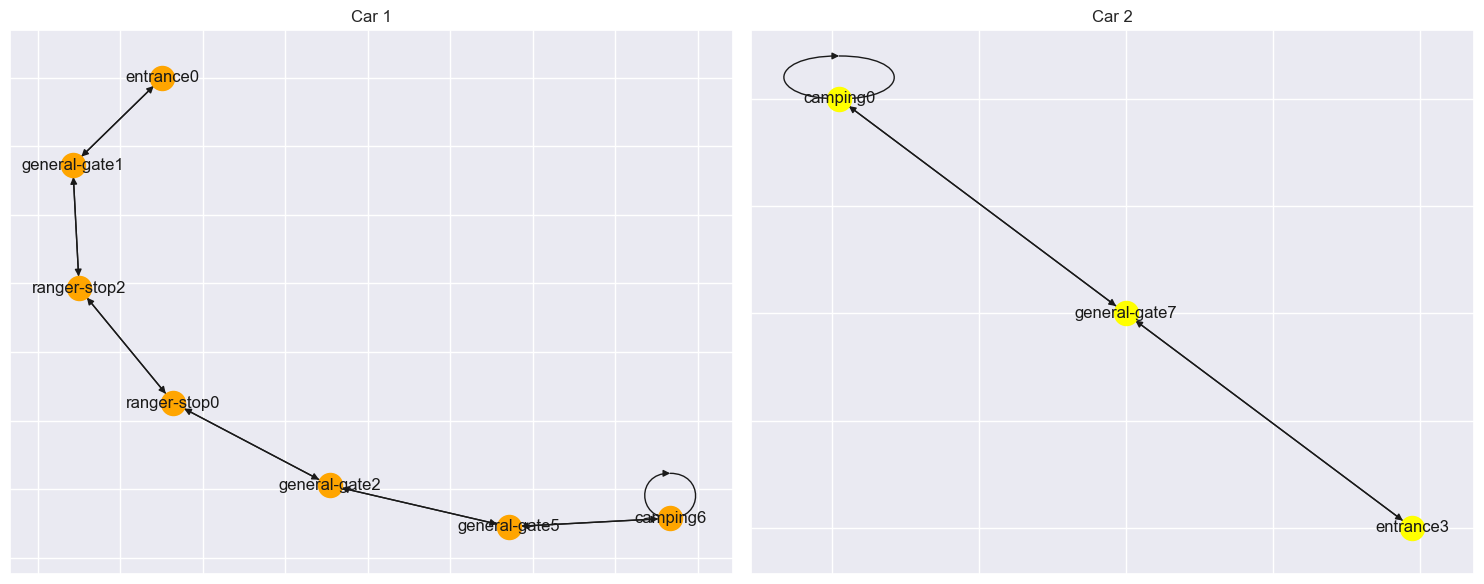

In [169]:
fig, ax = plt.subplots(1,2, figsize=(15,6), tight_layout=True) 
pos_381 = nx.spring_layout(graph_381,seed=63)
pos_717 = nx.spring_layout(graph_717,seed=63)

nx.draw_networkx_nodes(graph_381, pos_381,node_color="Orange",ax=ax[0])
ax[0].set_title("Car 1")
nx.draw_networkx_nodes(graph_717, pos_717,node_color="Yellow",ax=ax[1])
nx.draw_networkx_labels(graph_381, pos_381,ax= ax[0])
nx.draw_networkx_labels(graph_717, pos_717,ax= ax[1])

nx.draw_networkx_edges(graph_381, pos_381, edgelist= edges_381, arrows=True,ax=ax[0])
nx.draw_networkx_edges(graph_717, pos_717, edgelist= edges_717, arrows=True,ax=ax[1])
ax[1].set_title("Car 2")

plt.show()

# Route Analysis of car type 2p

In [167]:
root_dic = create_tree(data_dic['data']['2P'])
root = dict_to_tree(root_dic)
graph = tree_to_dot(root)
graph.write_png(os.path.join(path,"data/fig/cartype2P.png"))

# Route Analysis of Car type 2

In [38]:
root_dic = create_tree(data_dic['data']['2'])
root = dict_to_tree(root_dic)
graph = tree_to_dot(root)
graph.write_png(os.path.join(path,"data/fig/cartype2.png"))

In [57]:
max_length_route_cars_ids, max_length = get_max_length_routes(data_dic['data']["2"],1)

In [58]:
get_analomy_df(df,max_length_route_cars_ids,"2")

('20154519024544-322', '2015-06-19 14:45:44', '2015-10-05 00:36:54', 281)


In [60]:
tree_without_analomy = create_tree(data_dic['data']['2'],max_length_route_cars_ids)
root = dict_to_tree(tree_without_analomy)
graph = tree_to_dot(root)
graph.write_png(os.path.join(path,"data/fig/cartype2_without_analomy.png"))

In [62]:
analomy = create_tree(data_dic['data']['2'],None,max_length_route_cars_ids)
root = dict_to_tree(analomy)
graph = tree_to_dot(root)
graph.write_png(os.path.join(path,"data/fig/cartype2_analomy.png"))

### One cars of type 2 have unusual behavior

|  Car id  |  Entry Time  | Exit Time  |  N Gates | N Entrance Gates  | Total Time | Notes |
|---|---|---|---|---|---|---|
| 20154519024544-322  | 2015-06-19 14:45:44  | 2015-10-05 00:36:54 | 281 | 32 | 107 days 09:51:10 | First Entered from Entrance-1 and exited from entrance-4.then Entered and exited from entrance-4 fifteen times, but each time the car-id is same  |

* Please check the repeated behavior in below tree


In [161]:
df_322 = pd.read_csv(os.path.join(path,"data/anolomy/stayed_to_long/catype2_entries_281_20154519024544-322.csv"))

In [162]:
repeated_322 = get_repeated_behaviour_in_analomy(df_322)


In [174]:
edges_repeat_1 = [(repeated_322[0][i],repeated_322[0][i+1]) for i in range(len(repeated_322[0])-1)]
edges_repeat_2 = [(repeated_322[1][i],repeated_322[1][i+1]) for i in range(len(repeated_322[1])-1)]

In [175]:
graph_322_1 = nx.DiGraph()
graph_322_2 = nx.DiGraph()

graph_322_1.add_edges_from(edges_repeat_1)
graph_322_2.add_edges_from(edges_repeat_2)


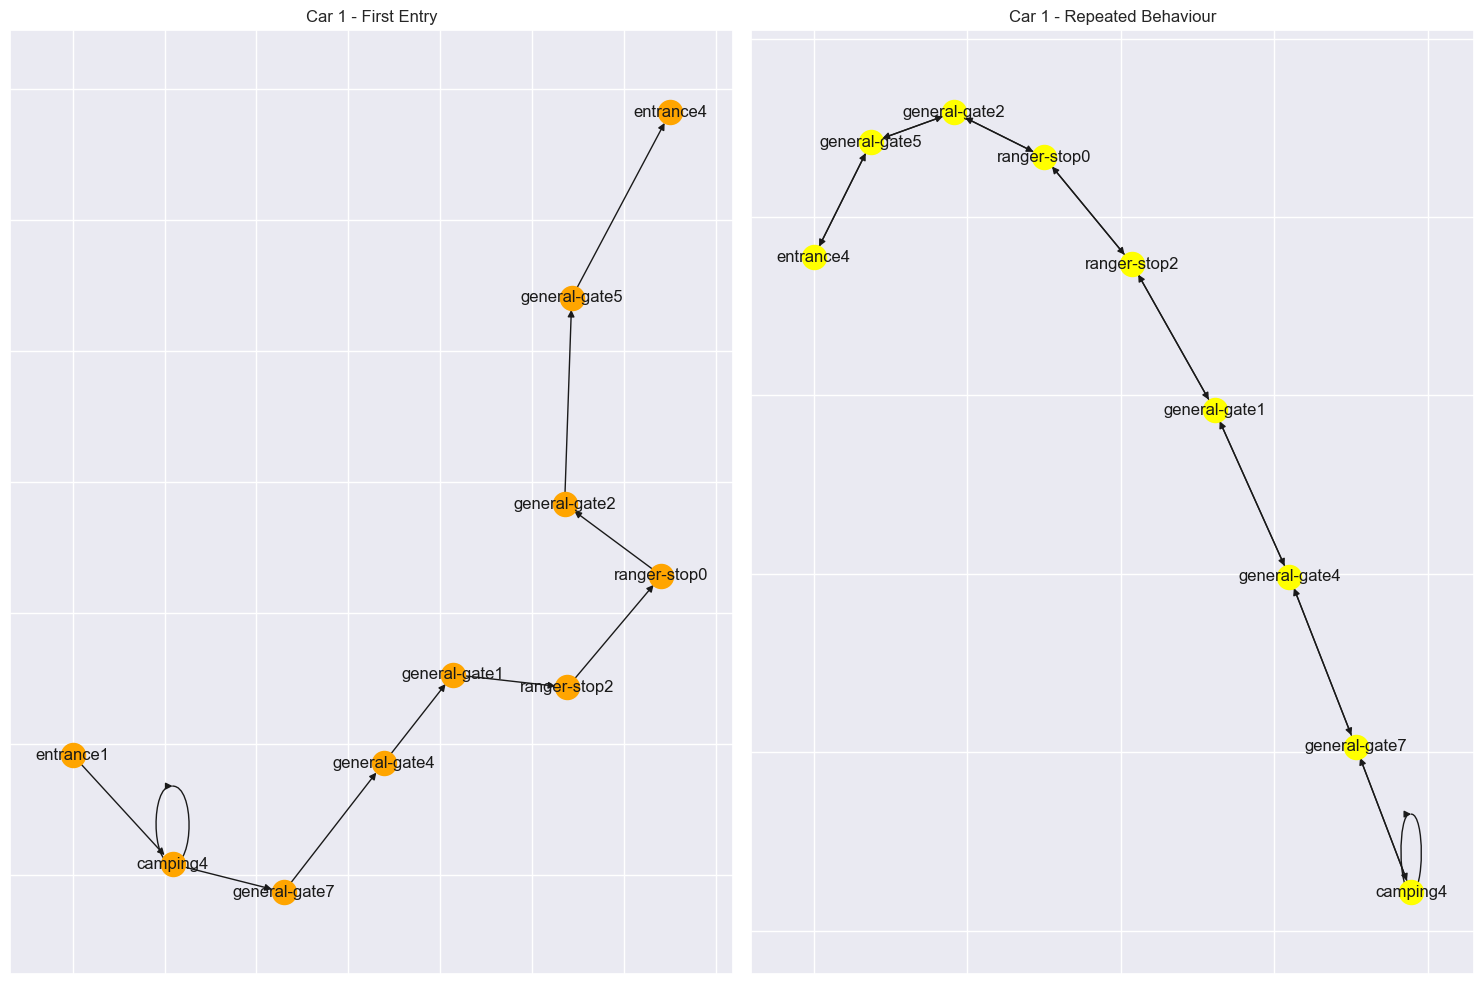

In [177]:
fig, ax = plt.subplots(1,2, figsize=(15,10), tight_layout=True) 
pos_1 = nx.spring_layout(graph_322_1,seed=63)
pos_2 = nx.spring_layout(graph_322_2,seed=63)

nx.draw_networkx_nodes(graph_322_1, pos_1,node_color="Orange",ax=ax[0])
ax[0].set_title("Car 1 - First Entry")
nx.draw_networkx_nodes(graph_322_2, pos_2,node_color="Yellow",ax=ax[1])
nx.draw_networkx_labels(graph_322_1, pos_1,ax= ax[0])
nx.draw_networkx_labels(graph_322_2, pos_2,ax= ax[1])

nx.draw_networkx_edges(graph_322_1, pos_1, edgelist= edges_repeat_1, arrows=True,ax=ax[0])
nx.draw_networkx_edges(graph_322_2, pos_2, edgelist= edges_repeat_2, arrows=True,ax=ax[1])
ax[1].set_title("Car 1 - Repeated Behaviour")

plt.show()

# Route Analysis of Car Type 3

In [63]:
root_dic = create_tree(data_dic['data']['3'])
root = dict_to_tree(root_dic)
graph = tree_to_dot(root)
graph.write_png(os.path.join(path,"data/fig/cartype3.png"))

# Route Analysis of Car Type 4

In [68]:
root_dic = create_tree(data_dic['data']['4'])
root = dict_to_tree(root_dic)
graph = tree_to_dot(root)
graph.write_png(os.path.join(path,"data/fig/cartype4.png"))

# Route Analysis of Car Type 5

In [95]:
root_dic = create_tree(data_dic['data']['5'])
root = dict_to_tree(root_dic)
graph = tree_to_dot(root)
graph.write_png(os.path.join(path,"data/fig/cartype5.png"))

# Route Analysis of Car Type 6

In [96]:
root_dic = create_tree(data_dic['data']['6'])
root = dict_to_tree(root_dic)
graph = tree_to_dot(root)
graph.write_png(os.path.join(path,"data/fig/cartype6.png"))

* cartype 5 and 6 take the same routes 